In [ ]:
from google.colab import files
uploaded = files.upload()

Saving credit_data.csv to credit_data.csv


In [ ]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['credit_data.csv']))
# Dataset is now stored in a Pandas Dataframe

In [ ]:
target = df["class"].values.tolist()
feature_names = list(df.columns.values)[:-1]
target_names= list(set(df["class"].values.tolist()))

In [ ]:
df = df.drop(columns=["class"])
data = df.to_numpy()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

data = enc.fit_transform(data)

In [ ]:
print(target.count('good'))
print(target.count('bad'))

700
300


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(data, target,test_size=0.1, random_state=0)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier()

tree_model.fit(data_train, target_train)

DecisionTreeClassifier()

## Accuracy Sobre el conjunto de prueba

In [ ]:
from sklearn.metrics import accuracy_score

target_predicted = tree_model.predict(data_test)

accuracy = accuracy_score(target_test, target_predicted)

print("El valor de accuracy obtenido es: {}".format(accuracy))

El valor de accuracy obtenido es: 0.69


## Accuracy sobre el conjunto de entrenamiento

In [ ]:
target_predicted = tree_model.predict(data_train)

accuracy = accuracy_score(target_train, target_predicted)

print("El valor de accuracy obtenido es: {}".format(accuracy))

El valor de accuracy obtenido es: 1.0


## Optimizar parámetros con GridSearchCV usando Accuracy

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth' : range(20)[1:],
              'min_samples_leaf': range(40)[1:],
              'min_samples_split': range(20)[2:],
              'criterion' :['gini', 'entropy']
             }

tree_clas = DecisionTreeClassifier()

clf = GridSearchCV(estimator=tree_clas, param_grid=param_grid, scoring="accuracy")
clf.fit(data_train, target_train)

final_model = clf.best_estimator_

print(clf.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 2}


In [ ]:
from sklearn.metrics import accuracy_score

target_predicted = final_model.predict(data_test)

accuracy = accuracy_score(target_test, target_predicted)

print("El valor de accuracy obtenido es: {}".format(accuracy))

El valor de accuracy obtenido es: 0.76


In [ ]:
target_predicted = final_model.predict(data_train)

accuracy = accuracy_score(target_train, target_predicted)

print("El valor de accuracy obtenido es: {}".format(accuracy))

El valor de accuracy obtenido es: 0.7588888888888888


## Poda por niveles

In [ ]:
from sklearn.tree._tree import TREE_LEAF
from copy import deepcopy

# Funcion para podar un árbol.

def is_leaf(tree_model, node_id):
  """
  Devuelve True si el nodo (node_id), pasado como
  argumento, es un nodo hoja del arbol (tree_model).
  Caso contrario retorna False.
  """
  return (tree_model.tree_.children_left[node_id] == TREE_LEAF and
          tree_model.tree_.children_right[node_id] == TREE_LEAF)


def prune(tree_model, levels=1):
  """
  Realiza la poda del arbol pasado como argumento, de forma recursiva, eliminando niveles del mismo.

  Esta funcion replica el funcionamiento de su correspondiente par en Matlab:

          prune(tree_model, 'level', levels)
  """
  tree_model_copy = deepcopy(tree_model)

  def recursive(tree_model, node_id):

    if (is_leaf(tree_model, tree_model.tree_.children_left[node_id]) and
        is_leaf(tree_model, tree_model.tree_.children_right[node_id])):
      tree_model.tree_.children_left[node_id] = TREE_LEAF
      tree_model.tree_.children_right[node_id] = TREE_LEAF

    if tree_model.tree_.children_left[node_id] != TREE_LEAF:
      recursive(tree_model, tree_model.tree_.children_left[node_id])
      recursive(tree_model, tree_model.tree_.children_right[node_id])

    return tree_model

  for _ in range(levels):
    tree_model_copy = recursive(tree_model_copy, 0)

  return tree_model_copy

In [ ]:
from sklearn.tree import plot_tree

models = [tree_model]

target_predicted = tree_model.predict(data_test)
accuracy_test = [accuracy_score(target_test, target_predicted)]

target_predicted = tree_model.predict(data_train)
accuracy_train = [accuracy_score(target_train, target_predicted)]

depths = [tree_model.get_depth()]

for i in range(1, tree_model.get_depth()+1):
  m = prune(models[i-1], 1)
  models.append(m)
  depths.append(depths[i-1]-1)
  target_predicted = m.predict(data_test)
  accuracy_test.append(accuracy_score(target_test, target_predicted))
  target_predicted = m.predict(data_train)
  accuracy_train.append(accuracy_score(target_train, target_predicted))

best_pruned_model = models[10]


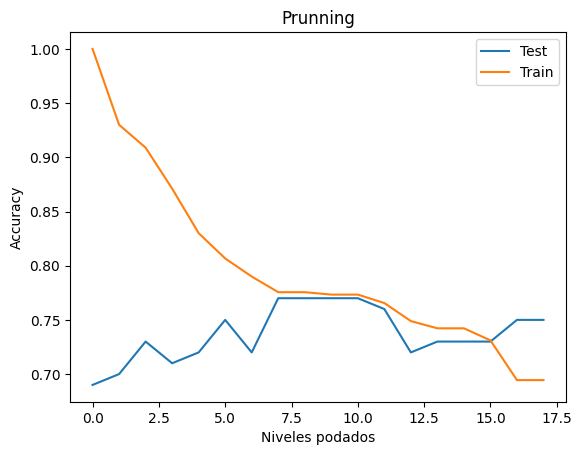

In [ ]:
import matplotlib.pyplot as plt

plt.plot(depths, accuracy_test[::-1], label="Test")
plt.plot(depths, accuracy_train[::-1], label="Train")

plt.xlabel("Niveles podados")
plt.ylabel("Accuracy")
plt.title('Prunning')
plt.legend()
plt.show()

## Evaluando los modelos anteriores

In [ ]:
from sklearn.metrics import precision_score

target_predicted = final_model.predict(data_test)

precision = precision_score(target_test, target_predicted, pos_label='good')

print("El valor de precision obtenido es: {}".format(precision))

El valor de precision obtenido es: 0.8493150684931506


In [ ]:
from sklearn.metrics import precision_score

target_predicted = best_pruned_model.predict(data_test)

precision = precision_score(target_test, target_predicted, pos_label='good')

print("El valor de precision obtenido es: {}".format(precision))

El valor de precision obtenido es: 0.8421052631578947


## Optimizando hiperparametros con GridSearch usando Precision

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer
custom_scorer = make_scorer(precision_score, greater_is_better=True,  pos_label='good')

param_grid_p = {'max_depth' : range(20)[1:],
              'min_samples_leaf': range(40)[1:],
              'min_samples_split': range(20)[2:],
              'criterion' :['gini', 'entropy']
             }

tree_clas = DecisionTreeClassifier()

clf = GridSearchCV(estimator=tree_clas, param_grid=param_grid_p, scoring=custom_scorer)
clf.fit(data_train, target_train)

final_model_p = clf.best_estimator_

print(clf.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 15}


In [ ]:
from sklearn.metrics import precision_score

target_predicted = final_model_p.predict(data_test)

precision = precision_score(target_test, target_predicted, pos_label='good')

print("El valor de precision obtenido es: {}".format(precision))

El valor de precision obtenido es: 0.8205128205128205


In [ ]:
from sklearn.metrics import accuracy_score

target_predicted = final_model_p.predict(data_test)

accuracy = accuracy_score(target_test, target_predicted)

print("El valor de accuracy obtenido es: {}".format(accuracy))

El valor de accuracy obtenido es: 0.75


## Prunning con precision

In [ ]:
from sklearn.tree import plot_tree

models_p = [tree_model]

target_predicted = tree_model.predict(data_test)
precision_test = [precision_score(target_test, target_predicted, pos_label='good')]

target_predicted = tree_model.predict(data_train)
precision_train = [precision_score(target_train, target_predicted, pos_label='good')]

depths_p = [tree_model.get_depth()]

for i in range(1, tree_model.get_depth()+1):
  m = prune(models_p[i-1], 1)
  models_p.append(m)
  depths_p.append(depths_p[i-1]-1)
  target_predicted = m.predict(data_test)
  precision_test.append(precision_score(target_test, target_predicted, pos_label='good'))
  target_predicted = m.predict(data_train)
  precision_train.append(precision_score(target_train, target_predicted, pos_label='good'))

best_pruned_model_p = models_p[10]

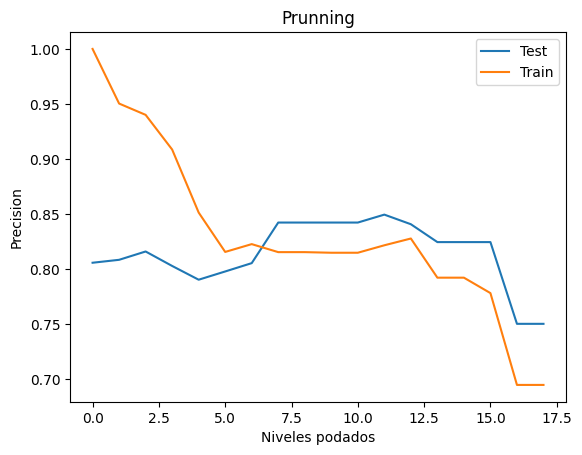

In [ ]:
import matplotlib.pyplot as plt

plt.plot(depths_p, precision_test[::-1], label="Test")
plt.plot(depths_p, precision_train[::-1], label="Train")

plt.xlabel("Niveles podados")
plt.ylabel("Precision")
plt.title('Prunning')
plt.legend()
plt.show()